### import modules

In [1]:
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['therof','barangay','ordinance','known','otherwise','city','davao','government','memorandum','code','sign','mayor','behalf','series','purposes','comprehensive','agreement','enter','section','entered','amended'])
# stop_words.extend(['ordinance','government','series','amending','otherwise','known','davao','city','government','sign','purposes','behalf','authorizing','providing',
# 'section','granting','providing','use','sign','code','thereof','agreement','enter','use','act','ii','xi','article','memorandum','barangay','mayor'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii','davao','sign','enter','amending','granting','authorizing','behalf','mayor','approving','authority'])

### Import Tagum dataset

In [4]:
df = pd.read_csv('ordinances/davao_ordinances.csv', header = 0)
print(df)
df.head()

            OR                                                 OT
0    000172-14  An Ordinance amending Section 42 of the 2005 R...
1    000177-14  An Ordinance placing underground all electrica...
2    000178-14  An Ordinance amending City Ordinance No. 0195-...
3    000173-14  An Ordinance regulating the use of some street...
4    000227-14  An ordinance for the creation of Trust Fund Ac...
..         ...                                                ...
414  000496-13  An Ordinance authorizing the City Mayor to ent...
415  000487-16  An Ordinance amending Section 13 Article XI of...
416  000348-07  Ordinance  Establishing the Gender-Sensitive C...
417  000349-07  ORDINANCE AMENDING DAVAO CITY ORDINANCE NO. 15...
418  000355-07  An  Ordinance  for  the  "Davao  Branding  Sys...

[419 rows x 2 columns]


,OR,OT
0,000172-14,An Ordinance amending Section 42 of the 2005 R...
1,000177-14,An Ordinance placing underground all electrica...
2,000178-14,An Ordinance amending City Ordinance No. 0195-...
3,000173-14,An Ordinance regulating the use of some street...
4,000227-14,An ordinance for the creation of Trust Fund Ac...


Add ordinance descriptions to a list

In [5]:
data = list(df.OT) 
print(data[:1]) # preview

['An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from "Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession" to "Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [6]:
import re
# data = [re.sub("\'", "", sent) for sent in data]
# data = [re.sub("\"", "", sent) for sent in data]
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]
data = [re.sub('\S*ing\S*\s?', '', sent) for sent in data]

<>:4: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
/var/folders/5w/v1hv7scs4gl14_30l_pjsrj00000gn/T/ipykernel_2076/2294170431.py:4: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]
/var/folders/5w/v1hv7scs4gl14_30l_pjsrj00000gn/T/ipykernel_2076/2294170431.py:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*ing\S*\s?', '', sent) for sent in data]


Tokenize and preprocess text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'section',
  'of',
  'the',
  'revenue',
  'code',
  'of',
  'davao',
  'city',
  'from',
  'time',
  'and',
  'place',
  'of',
  'the',
  'payment',
  'the',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'in',
  'advance',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'before',
  'the',
  'materials',
  'are',
  'extracted',
  'and',
  'shall',
  'be',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'for',
  'quarry',
  'concession',
  'to',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'every',
  'quarter',
  'of',
  'the',
  'calendar',
  'year',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'after',
  'the',
  'materials',
  'are',
  'extracted',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'for',
  'quarry

In [8]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 2), (7, 2), (8, 2), (9, 1), (10, 2), (11, 2), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 2), (18, 1), (19, 3), (20, 2), (21, 1), (22, 2), (23, 2), (24, 1)]]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('application', 2),
  ('applied', 2),
  ('authorized', 2),
  ('based', 2),
  ('calendar', 1),
  ('concession', 2),
  ('due', 2),
  ('duly', 2),
  ('every', 1),
  ('extracted', 2),
  ('materials', 2),
  ('payable', 2),
  ('payment', 1),
  ('place', 1),
  ('quarry', 2),
  ('quarter', 1),
  ('representative', 2),
  ('revenue', 1),
  ('shall', 3),
  ('tax', 2),
  ('time', 1),
  ('treasurer', 2),
  ('volume', 2),
  ('year', 1)]]

In [10]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,workers=3,
                                           num_topics=15, 
                                           random_state=123,
                                           
                                           chunksize=100,
                                           passes=30,
                                          
                                           per_word_topics=True)

In [11]:
doc_lda = lda_model[corpus]

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

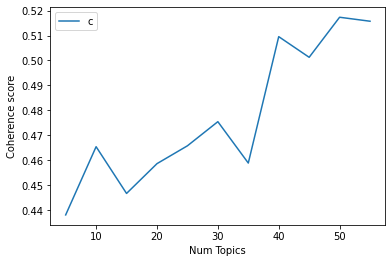

Model: ( 0 ) Num Topics = 5  has Coherence Value of 0.4381
Model: ( 1 ) Num Topics = 10  has Coherence Value of 0.4654
Model: ( 2 ) Num Topics = 15  has Coherence Value of 0.4467
Model: ( 3 ) Num Topics = 20  has Coherence Value of 0.4586
Model: ( 4 ) Num Topics = 25  has Coherence Value of 0.4658
Model: ( 5 ) Num Topics = 30  has Coherence Value of 0.4755
Model: ( 6 ) Num Topics = 35  has Coherence Value of 0.4589
Model: ( 7 ) Num Topics = 40  has Coherence Value of 0.5096
Model: ( 8 ) Num Topics = 45  has Coherence Value of 0.5013
Model: ( 9 ) Num Topics = 50  has Coherence Value of 0.5173
Model: ( 10 ) Num Topics = 55  has Coherence Value of 0.5157


In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
model_number = -1
for m, cv in zip(x, coherence_values):
    model_number += 1
    print("Model: (", model_number,") Num Topics =", m, " has Coherence Value of", round(cv, 4))

K = 15 is the optimal number of topics since when

In [22]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(14,
  '0.040*"operation" + 0.039*"scheme" + 0.027*"smile" + 0.018*"operations" + '
  '0.018*"grande" + 0.018*"catalunan" + 0.017*"utility" + 0.017*"penalty" + '
  '0.016*"public" + 0.015*"within"'),
 (23,
  '0.054*"revenue" + 0.024*"article" + 0.022*"paragraph" + 0.022*"rodrigo" + '
  '0.022*"duterte" + 0.019*"pesos" + 0.019*"hundred" + 0.019*"brother" + '
  '0.013*"partnership" + 0.013*"small"'),
 (24,
  '0.021*"health" + 0.021*"insurance" + 0.021*"philhealth" + 0.021*"indigent" '
  '+ 0.017*"national" + 0.014*"proceeds" + 0.014*"creation" + 0.014*"tax" + '
  '0.014*"cruz" + 0.014*"sta"'),
 (10,
  '0.046*"halal" + 0.044*"food" + 0.021*"use" + 0.016*"business" + '
  '0.016*"sugar" + 0.013*"within" + 0.013*"muslim" + 0.013*"cemetery" + '
  '0.010*"word" + 0.010*"logo"'),
 (15,
  '0.024*"peace" + 0.024*"use" + 0.021*"wine" + 0.020*"thereof" + '
  '0.019*"operation" + 0.019*"land" + 0.018*"plan" + 0.016*"volume" + '
  '0.016*"conflict" + 0.016*"program"'),
 (2,
  '0.040*"donation" + 0.0

In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,23.0,0.9775,"revenue, article, paragraph, rodrigo, duterte, pesos, hundred, brother, partnership, small","An Ordinance Section 42 of the 2005 Revenue Code of Davao City from ""Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession"" to ""Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"""
1,1,0.0,0.9033,"department, project, education, park, ko, pwede, paaralan, magrehistro, sa, implementation",An Ordinance underground all electrical and telecommunication wires and cables within the vicinity of City Hall and the Sangguniang Panlungsod of the City of Davao
2,2,2.0,0.3761,"donation, per, deed, day, executed, favor, square, meter, district, road","An Ordinance City Ordinance No. 0195-14, Series of 2004, otherwise known as the ""Amended scheme of Davao City"" for a 90-day experimental period"
3,3,15.0,0.6646,"peace, use, wine, thereof, operation, land, plan, volume, conflict, program","An Ordinance the use of some streets near the Mintal Public Market in Barangay Mintal, Tugbok District, this city"
4,4,5.0,0.6370,"investment, incentive, center, construction, article, permit, regulations, rules, los, amigos",An ordinance for the creation of Trust Fund Account for the Office of the Official and procedural guidelines for the disposition and use of the Fifteen Percent (15%) generated from permit fees and other charges under the National Code of the Philippines (PD 1096)
5,5,6.0,0.5167,"social, development, construction, implementation, welfare, authority, department, classrooms, dswd, relative",An ordinance the Tourism Code of Davao City
6,6,6.0,0.4046,"social, development, construction, implementation, welfare, authority, department, classrooms, dswd, relative","An Ordinance Legislative Authority to City Mayor Rodrigo R. Duterte to enter into and sign, for and in behalf of the City Government of Dava (CGD), the Partnership Agreement between the Philippine Commission on Women and the City Government of Davao for the implementation of the Local Gender and Development Resource Program in Davao City"
7,7,3.0,0.6054,"relative, local, partners, inc, among, development, program, lot, road, authority","An ordinance legislative authority to City Mayor Rodrigo R. duterte, to sign for and in behalf of the City Government of Davao the Memorandum of to be entered into by and between Alsons Development & Investment Corporation (ALSONS DEV) and the City Government of Davao relative to the establishment of 911 Satellite Office in Cabantian, Davao City"
8,8,1.0,0.6031,"jurisdiction, within, food, territorial, ii, use, act, salumay, datu, meat",An Ordinance motorcades within the territorial jurisdiction of Davao City
9,9,23.0,0.4570,"revenue, article, paragraph, rodrigo, duterte, pesos, hundred, brother, partnership, small","An ordinance the City Mayor, Rodrigo R. Duterte, to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of (MOU) of the Friendship City Agreement between Davao City and Lucena City"


In [24]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(55)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9688,"department, project, education, park, ko, pwede, paaralan, magrehistro, sa, implementation","retailers, wholesalers, grocery stores, convenience stores and other businesses from or to be sold to minors in their respective stores and establishments cigarettes and other tobacco products, beer, liquor and other beverages and minors aged 17 and below from or beer, liquor, coconut wines and other beverages, as well as or cigarettes & other tobacco products, etc."
1,1.0,0.9758,"jurisdiction, within, food, territorial, ii, use, act, salumay, datu, meat",AN ORDINANCE THE CITY MAYOR TO IMPLEMENT THE NEW RATES OF REPRESENTATION AND TRANSPORTATION ALLOWANCES (RATA) OF THE SANGGUNIANG PANLUNGSOD (SP) MEMBERS AND CITY GOVERNMENT DEPARTMENT HEAD II (CGDH II) OF THE CITY GOVERNMENT OF DAVAO EFFECTIVE JANUARY 2010 ON THE BASIS OF REPUBLIC ACT NO. 9970 (RA 9970) OR THE GENERAL APPROPRIATIONS ACT OF FISCAL YEAR 2010 (GAA FY 2010) AND TO COLLECT THE DIFFERENCE OF P200.00 PER MONTH CHARGEABLE AGAINST THE LUMPSUM MISCELLANEOUS PERSONNEL BENEFITS FUND
2,2.0,0.9770,"donation, per, deed, day, executed, favor, square, meter, district, road","ORDINANCE ORDINANCE NO. 0158-05, SERIES OF 2005, OTHERWISE KNOWN AS ""THE 2005 REVENUE CODE OF THE CITY OF DAVAO"" PARTICULARLY ARTICLE 30, SECTION 232 THEREOF, BY AND/OR THE RATES OF THE AMBULANT FEE (SPACE OCCUPIED PER SQUARE METER PER DAY) FROM ""TWENTY-FIVE PESOS (P25.00)"" PER SQUARE METER PER DAY TO ""FIFTEEN PESOS (P15.00)"" PER SQUARE METER PER DAY FOR THE PERIOD DECEMBER 7, 2010 TO JANUARY 2, 2011 ONLY IN CONNECTION WITH THE ""PASKO STREET MARKET"" ONE OF THE ACTIVITIES OF PASKO FIESTA SA DAVAO 2010"
3,3.0,0.9698,"relative, local, partners, inc, among, development, program, lot, road, authority","AN ORDINANCE THE CITY MAYOR TO IMPLEMENT THE ADJUSTED RATES OF SPECIAL COUNSEL ALLOWANCE PAID TO LAWYER-PERSONNEL THOSE DESIGNATED TO ASSUME THE DUTIES OF A LEGAL OFFICER AND THOSE IN THE LEGAL STAFF OF DEPARTMENTS, BUREAUS, AND OFFICES IN THE CITY GOVERNMENT OF DAVAO EFFECTIVE JANUARY 2010 ON THE BASIS OF SECTION 52 OF REPUBLIC ACT NO. 9970 OR THE GENERAL APPROPRIATIONS ACT OF FISCAL YEAR 2010 (GAA FY 2010)"
4,4.0,0.9628,"authority, legislative, inc, support, self, tower, office, meter, globe, district","AN ORDINANCE LEGISLATIVE AUTHORITY TO EFB GEOSTRUCKT, INC. FOR THE CONSTUCTION, INSTALLATION AND OPERATION OF GLOBE TELECOM`S 40.0 METER 3-LEGGED SELF SUPPORT CELL SITE TOWER AT TIGATTO ROAD, BREAD VILLAGE, BARANGAY BUHANGIN PROPER, BUHANGIN DISTRICT,THIS CITY"
5,5.0,0.9698,"investment, incentive, center, construction, article, permit, regulations, rules, los, amigos","An Ordinance all individuals, private and public offices or entities to use ""Kagan"" not ""Kalagan"" in their files, data, records and other documents when to the Kagan Tribe as defined in this Act, for publication, public display, public use and for other purposes and to correct all their files, data, records, and other documents to reflect the tribe`s name as ""Kagan"" not ""Kalagan"""
6,6.0,0.9752,"social, development, construction, implementation, welfare, authority, department, classrooms, dswd, relative","AN ORDINANCE LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO ENTER INTO AND SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, THE DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNMENT OF BARANGAY GUMITAN RELATIVE TO THE CONSTRUCTION OF TWO (2) CLASSROOMS AT SITIO KIBANGBANG, BARANGAY GUMITAN, MARILOG DISTRICT,IN THE AMOUNT OF ONE MILLION FIVE HUNDRED SEVENTY THOUSAND PESOS (P1,570,000.00)"
7,7.0,0.9396,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","An Ordinance and a portion of 1.7 hectares of lan

In [25]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 7.0]

df_sorted_by_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
23,23,7.0,0.4482,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management",An ordinance the establishment of a hostel at the Davao City Overland Transport Terminal (DCOTT) its rental rates and for other purposes
74,74,7.0,0.4067,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","An Ordinance and the health facility in Barangay Tibungco as ""City Government of Davao Tibungco"
157,157,7.0,0.7294,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","the manufacture, sale, distribution, possession or use of firecrackers or pyrotechnic devices and such other similar devices and the of firecrackers or other similar explosives within the territorial jurisdiction of Davao City"
209,209,7.0,0.9396,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","An Ordinance and a portion of 1.7 hectares of land within the Commercial 2 (C-2) District of the SIR Project site at New Matina, City of Davao, and said area as bus terminal for the City of Davao."
239,239,7.0,0.8792,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","AN ORDINANCE ORDINANCE NO. 110, SERIES OF 1986, OTHERWISE KNOWN AS THE “DAVAO CITY OVERLAND TRANSPORT TERMINAL ORDINANCE”, BY THE TERMINAL AND RENTAL FEES THEREIN"
250,250,7.0,0.3445,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management",An ordinance a Program for all infants in Davao City
256,256,7.0,0.5057,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management",An ordinance the City Transport and Traffic Management Office (CTTMO)
273,273,7.0,0.4482,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management","An ordinance further Ordinance No. 110, Series of 1986, otherwise known as ""The Davao City Overland Transport Terminal Ordinance"" particlarly Article 3, Section 8, Paragraph 5 (d) as amended by Ordinance No. 084-08, Series of 2008, by the rates therein"
281,281,7.0,0.8067,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management",An ordinance for the proper storage and utilization of rainwater in Davao City
335,335,7.0,0.6778,"sale, new, matina, deed, transport, program, traffic, terminal, facility, management",An Ordinance for the Comprehensive Transport and Traffic Code of Davao City


In [18]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)



/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [19]:
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=15,
#                   colormap='tab20',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# topics = optimal_model.show_topics(num_topics=15,formatted=False)

# fig, axes = plt.subplots(3, 5, figsize=(12,8), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [20]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# # These are the "Tableau 20" colors as RGB.    
# tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
#              (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
#              (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
#              (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
#              (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
# for i in range(len(tableau20)):    
#     r, g, b = tableau20[i]    
#     tableau20[i] = (r / 255., g / 255., b / 255.)
    
# for i, ax in enumerate(axes.flatten()):    
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
#     doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
#     ax.hist(doc_lens, bins = 700, color=tableau20[i])
#     ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
#     sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
#     ax.set(xlim=(0, 700), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=tableau20[i])
#     ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,700,9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()

In [21]:

# # Sentence Coloring of N Sentences
# from matplotlib.patches import Rectangle

# def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
#     corp = corpus[start:end]
#     mycolors = tableau20

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()